<a href="https://colab.research.google.com/github/fiedler-m/pitch_predictor/blob/main/Pitch_Sequence_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input, Dropout, LSTM, TimeDistributed, BatchNormalization, Lambda, RepeatVector
from keras.layers.core import Dense
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.utils import Sequence, plot_model
from keras import backend as K
from keras.layers import LeakyReLU

from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username":"matthewfiedler","key":"c4417ea1db8941fabeee5e58fb7104eb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list

- path is now set to: {/content}
ref                                                    title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
gpreda/covid-world-vaccination-progress                COVID-19 World Vaccination Progress                  32KB  2021-01-25 12:35:25           1642  
google/android-smartphones-high-accuracy-datasets      Android smartphones high accuracy GNSS datasets       1GB  2020-12-23 01:51:11            644  
ayushggarg/all-trumps-twitter-insults-20152021         All Trump's Twitter insults (2015-2021)             581KB  2021-01-20 16:51:05            268  
cdminix/us-drought-meteorological-data                 US Drought & Meteorological Data                    748MB  2021-01-20 21:48:02             73  
sevgisarac/temperature-change                          Temper

In [ ]:
!kaggle datasets download -d pschale/mlb-pitch-data-20152018 -p/content

 98% 361M/370M [00:03<00:00, 85.4MB/s]
100% 370M/370M [00:03<00:00, 112MB/s] 


In [ ]:
!unzip \*.zip

Archive:  mlb-pitch-data-20152018.zip
  inflating: 2019_atbats.csv         
  inflating: 2019_games.csv          
  inflating: 2019_pitches.csv        
  inflating: atbats.csv              
  inflating: ejections.csv           
  inflating: games.csv               
  inflating: pitches.csv             
  inflating: player_names.csv        


In [ ]:
df = pd.read_csv('pitches.csv')
df.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,34.685,-11.960,1.72,3.56,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,4.16,10.93,55.0,3.0,C,S,FF,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,34.225,-10.085,1.72,3.56,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,6.57,12.00,31.0,5.0,S,S,FF,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,35.276,-11.560,1.72,3.56,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,7.61,10.88,49.0,1.0,F,S,FF,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,28.354,-20.540,1.74,3.35,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,1.17,6.45,41.0,13.0,B,B,FF,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,21.774,-34.111,1.72,3.56,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,-8.43,-1.65,18.0,13.0,B,B,CU,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [ ]:
#data 

t = time()

enc_dict = {'Single': '1B','Double': '2B','Triple': '3B','Home Run': 'HR','Walk': 'BB',
            'Intent Walk': 'IBB','Hit By Pitch': 'HBP','Strikeout': 'K','Sac Fly': 'SF',
            'Grounded Into DP': 'GIDP','Groundout': 'GO','Lineout': 'LO','Pop Out': 'PO',
            'Flyout': 'FO','Fielders Choice': 'FC','Sac Bunt': 'SAC','Double Play': 'DP',
            'Triple Play': 'TP','Batter Interference': 'BI','Fan interference': 'FI',
            'Catcher Interference': 'CI','Field Error': 'ROE','Bunt Groundout': 'BGO',
            'Bunt Lineout': 'BLO','Bunt Pop Out': 'BPO','Fielders Choice Out': 'FCO',
            'Forceout': 'FORCE','Sacrifice Bunt DP': 'SBDP','Strikeout - DP': 'KDP',
            'Runner Out': 'RO','Sac Fly DP': 'SFDP'
           }

pitches = pd.read_csv('pitches.csv')
pitches = pitches[pitches['ab_id'] > 2018*1e6]
atbats = pd.read_csv('atbats.csv', index_col=0)
atbats = atbats[atbats.index > 2018*1e6]
atbats['year'] = (atbats.index//1e6).astype(int)
atbats['stand'] = atbats['stand'] == 'R'
atbats['p_throws'] = atbats['p_throws'] == 'R'
atbats['event'] = atbats['event'].apply(lambda x: enc_dict[x])
eventcol = atbats['event']
atbats = pd.get_dummies(atbats, columns=['event'], prefix='')
atbats['event'] = eventcol

pitches['spin_rate'] = pitches['spin_rate'] / 1000
pitches['start_speed'] = pitches['start_speed'] / 50
pitches['spin_dir'] = pitches['spin_dir'] / 100

atbats['_H'] = atbats[['_1B', '_2B', '_3B', '_HR']].sum(axis=1)
atbats['_TB'] = atbats['_1B'] + 2*atbats['_2B'] + 3*atbats['_3B'] + 4*atbats['_HR']
atbats['_K'] = atbats['_K'] + atbats['_KDP']
atbats['_BB'] = atbats['_BB'] + atbats['_IBB']
atbats['_AB'] = 1 - atbats[['_CI', '_SAC', '_BB', 
                            '_HBP', '_RO', '_SF']].sum(axis=1)
atbats['_PA'] = 1 - atbats['_RO']

atbats['_outs'] = atbats['o'] - atbats.groupby(['g_id', 
                                                'inning', 
                                                'top'])['o'].shift(1).fillna(0)

stats_to_cum = pd.Index(['H', 'TB', 'PA', 'AB', 'BB', 'HBP', 'IBB', 'K', 
                         '2B', '3B', 'HR', 'GIDP', 'SF'])

batter_groups = atbats.groupby(['batter_id', 'year'])
pitcher_groups = atbats.groupby(['pitcher_id', 'year'])

atbats[stats_to_cum] = (batter_groups['_' + stats_to_cum]
                                     .transform(pd.Series.cumsum)).astype(int)

atbats['opp_' + stats_to_cum] = (pitcher_groups['_' + stats_to_cum]
                                               .transform(pd.Series.cumsum)).astype(int)
atbats['IP'] = pitcher_groups['_outs'].transform(pd.Series.cumsum) / 3

atbats['AVG'] = atbats['H']/atbats['AB']
atbats['SLG'] = atbats['TB']/atbats['AB']
atbats['OBP'] = atbats[['H', 'BB', 'HBP']].sum(axis=1)/atbats[['AB', 'BB', 'HBP', 
                                                               'SF']].sum(axis=1)
atbats['OPS'] = atbats['SLG'] + atbats['OBP']
atbats['K%'] = atbats['K'] / atbats['AB']
atbats['BB%'] = atbats['BB'] / atbats['AB']
atbats['K-BB%'] = atbats['K%'] - atbats['BB%']
atbats['BABIP'] = (atbats['H'] - atbats['HR'])/(atbats['AB'] + atbats['SF'] 
                                                          - atbats['HR'] - atbats['K'])
atbats['ISO'] = atbats['SLG'] - atbats['AVG']

atbats['opp_AVG'] = atbats['opp_H']/atbats['opp_AB']
atbats['opp_SLG'] = atbats['opp_TB']/atbats['opp_AB']
atbats['opp_OBP'] = (atbats[['opp_H', 'opp_BB', 'opp_HBP']].sum(axis=1) / 
                             atbats[['opp_AB', 'opp_BB', 
                                     'opp_HBP', 'opp_SF']].sum(axis=1))
atbats['opp_OPS'] = atbats['opp_SLG'] + atbats['opp_OBP']
atbats['opp_K%'] = atbats['opp_K'] / atbats['opp_AB']
atbats['opp_BB%'] = atbats['opp_BB'] / atbats['opp_AB']
atbats['opp_K-BB%'] = atbats['opp_K%'] - atbats['opp_BB%']
atbats['opp_BABIP'] = ((atbats['opp_H'] - atbats['opp_HR'])/
                               (atbats['opp_AB'] + atbats['opp_SF'] - 
                                atbats['opp_HR'] - atbats['opp_K']))

atbats['FIP'] = (13*atbats['opp_HR'] + 3*(atbats['opp_BB'] + atbats['opp_HBP']) 
                 - 2.0*atbats['opp_K'])/atbats['IP'] + 3.2
atbats['WHIP'] = atbats[['opp_H', 'opp_BB']].sum(axis=1)/atbats['IP']

atbats.replace(np.inf, 0, inplace=True)
atbats.replace(-np.inf, 0, inplace=True)

batter_stats_cols = ['stand', 'AB', 'AVG', 'OBP', 'SLG', 'OPS', 'K%', 'BB%', 'BABIP']
pitcher_stats_cols = ['p_throws', 'IP', 'opp_AVG', 'opp_OBP', 'opp_SLG', 'opp_OPS', 'opp_K%',
                      'opp_BB%', 'opp_BABIP', 'FIP', 'WHIP']
other_cols = ['batter_id', 'g_id', 'inning', 'o', 'p_score', 'pitcher_id', 'top', 'year', 'event']

atbats = atbats[other_cols + batter_stats_cols + pitcher_stats_cols].fillna(0)

pitches.loc[pitches['pitch_type'].isna(), 'pitch_type'] = 'UN'
pitches.loc[pitches['pitch_type'].isin(['SC', 'AB', 'EP', 'FA']), 'pitch_type'] = 'UN'
pitches.loc[pitches['pitch_type'] == 'FO', 'pitch_type'] = 'PO'

home_sp = (atbats[(atbats['inning']==1) & 
                  (atbats['top'])].groupby('g_id')
                                  .head(n=1)
                                  .set_index('g_id')['pitcher_id']
                                  .rename('home_sp'))
away_sp = (atbats[(atbats['inning']==1) & 
                  ~(atbats['top'])].groupby('g_id')
                                   .head(n=1)
                                   .set_index('g_id')['pitcher_id']
                                   .rename('away_sp'))

starting_pitchers = home_sp.to_frame().join(away_sp, how='left', on='g_id')
atbats = atbats.join(starting_pitchers, on='g_id', how='left')


atbats['is_starter'] = ((atbats['pitcher_id'] == atbats['home_sp']) | 
                                (atbats['pitcher_id'] == atbats['away_sp']))
atbats.drop(columns=['home_sp', 'away_sp'], inplace=True)

outing_stats = pitches[['ab_id']].copy()
outing_stats = outing_stats.join(atbats[['pitcher_id', 'batter_id', 
                                         'g_id', 'inning', 'top']], on='ab_id')
pitches['prev_pitches'] = outing_stats.groupby(['pitcher_id','g_id']).cumcount()
prev_pitch_ab = (pitches.groupby('ab_id')[['ab_id', 'prev_pitches']]
                        .head(n=1).set_index('ab_id'))
pitches.drop('prev_pitches', axis=1)
avg_start_len = 90
avg_relief_len = 17

avg_outing_len = (outing_stats.groupby(['pitcher_id', 'g_id']).size()
                              .rolling(window=10, min_periods=1).mean()
                              .groupby(['pitcher_id'])
                              .transform(lambda x: x.shift(1))) 

atbats = atbats.join(avg_outing_len.rename('avg_outing_len'), 
                     on=['pitcher_id', 'g_id'], how='left')
atbats.loc[atbats['avg_outing_len'].isna() & 
            atbats['is_starter'], 'avg_outing_len'] = avg_start_len
atbats.loc[atbats['avg_outing_len'].isna() & 
           ~atbats['is_starter'], 'avg_outing_len'] = avg_relief_len

p = pitches.join(atbats[['pitcher_id']], on='ab_id')[['pitcher_id', 'pitch_type', 
                                                      'spin_dir', 'ab_id', 'pitch_num']]
p['spin_dir_shifted'] = ((pitches['spin_dir'] + 1.8) % 3.6) - 1.8
p.loc[p['pitch_type'].isna(), 'pitch_type'] = 'UN'
p_grouped = p.groupby(['pitcher_id', 'pitch_type'])
should_shift = (p_grouped['spin_dir'].std() 
                - p_grouped['spin_dir_shifted'].std()) > 0.01 
                # making this 0.01 instead of 0 b/c floating point errors

p = p.join(should_shift.rename('should_shift'), on=['pitcher_id', 'pitch_type'], how='left')
pitches['spin_dir'] = p['spin_dir'].where(p['should_shift'], p['spin_dir_shifted'])
del p, should_shift, p_grouped

traj_cols = ['start_speed', 'spin_rate', 'spin_dir']
pt = pitches[['ab_id','pitch_type'] + traj_cols]
pt = pt.join(atbats[['pitcher_id', 'batter_id', 'year']], how='left', on='ab_id')
old_cols = pt.columns
pt = pd.get_dummies(pt, columns=['pitch_type'], prefix='')
pt.drop(['_UN', '_PO'], axis=1, inplace=True)
pt_dummy_cols = pt.columns.drop(old_cols.drop('pitch_type'))

pitches_grouped = pt.groupby('ab_id')
pitches_during_ab = pitches_grouped[pt_dummy_cols].sum()
pitches_during_ab['tot_cat'] = pitches_during_ab.sum(axis=1)
pitches_during_ab['tot'] = pitches_grouped.size()
pitches_during_ab = pitches_during_ab.merge(atbats[['pitcher_id', 'batter_id', 'year']], 
                                            left_index=True, right_index=True)

pfreq_pitcher = (pitches_during_ab.groupby(['pitcher_id', 'year'])
                                   [list(pt_dummy_cols) + ['tot', 'tot_cat']]
                                  .rolling(window=50, min_periods=1).sum())
pfreq_pitcher = pfreq_pitcher.groupby(['pitcher_id', 'year']).shift(1)
pfreq_pitcher = (pfreq_pitcher[pt_dummy_cols].div(pfreq_pitcher['tot_cat'],axis=0)
                                             .fillna(0).reset_index()
                                             .set_index('ab_id'))

pfreq_batter = (pitches_during_ab.groupby(['batter_id', 'year'])
                                 [list(pt_dummy_cols) + ['tot', 'tot_cat']]
                                 .rolling(window=50, min_periods=1).sum())
pfreq_batter = pfreq_batter.groupby(['batter_id', 'year']).shift(1)
pfreq_batter = (pfreq_batter[pt_dummy_cols].div(pfreq_batter['tot_cat'],axis=0)
                                           .fillna(0).reset_index()
                                           .set_index('ab_id'))

pt = pitches[['pitch_type', 'ab_id'] + traj_cols]
pt = pt.join(atbats[['pitcher_id', 'batter_id', 'year']], on='ab_id')
pt.index.name = 'pID'
grouped_rolling = (pt.groupby(['pitcher_id', 'year', 'pitch_type'])[traj_cols]
                     .rolling(window=20, min_periods=1))

traj_means = grouped_rolling.mean().fillna(0)

traj_means = traj_means.unstack(level=2)

traj_means = (traj_means.set_axis([f"{y}_{x}_m" for x, y in traj_means.columns], 
                                  axis=1, inplace=False)
                        .reset_index()
                        .set_index('pID'))

traj_stds = grouped_rolling.std().fillna(0)
traj_stds = traj_stds.unstack(level=2)
traj_stds = (traj_stds.set_axis([f"{y}_{x}_std" for x, y in traj_stds.columns], 
                                axis=1, inplace=False)
                       .reset_index()
                       .set_index('pID'))
traj_stats = (traj_means.merge(traj_stds, left_index=True, 
                               right_index=True, on=['pitcher_id', 'year'])
                         .sort_values(by='pID'))

traj_stats = (traj_stats.groupby(['pitcher_id', 'year'])
                       .fillna(method='ffill')
                       .shift(1).fillna(0))

traj_stats = (traj_stats.merge(pt[['ab_id']], left_index=True, right_index=True)
                        .groupby('ab_id').head(n=1).set_index('ab_id'))

spindir_mean_cols = [ele for ele in atbats.columns if 'spin_dir_m' in ele]
traj_stats[spindir_mean_cols] = atbats[spindir_mean_cols] % 3.6

atbats = atbats.merge(pfreq_pitcher, left_index=True, 
                      right_index=True, on=['pitcher_id', 'year'])
atbats = atbats.merge(pfreq_batter, left_index=True, 
                      right_index=True, on=['batter_id', 'year'], suffixes=['_p', '_b'])

atbats = atbats.merge(traj_stats, left_index=True, right_index=True)
atbats = atbats.merge(prev_pitch_ab, left_index=True, right_index=True)
atbats.index = atbats.index.astype(int)

numpitches = pitches.groupby('ab_id').size().rename('num_pitches')
pitches = pitches.join(numpitches, on='ab_id')
atbats = atbats.join(numpitches, on='ab_id')
print('Loaded and processed data in {:4.2f} seconds'.format(time()-t))

Loaded and processed data in 39.65 seconds


In [ ]:
pitches.loc[pitches['code'].isin(['X', 'D', 'E']), 'code'] = np.nan
code_cols = list(pitches['code'].dropna().unique())
pt_cols = list(pitches['pitch_type'].unique())
pitches = pd.get_dummies(pitches, columns=['pitch_type', 'code'], prefix_sep='', prefix='')

pitches.fillna({'px': 0, 'pz': 0}, inplace=True)

freq_traj_stats = (list(pfreq_pitcher.columns.drop(['pitcher_id', 'year']) + '_p') + 
                  list(pfreq_batter.columns.drop(['batter_id', 'year']) + '_b') + 
                  list(traj_stats.columns) + 
                  list(prev_pitch_ab.columns))

static_cols = freq_traj_stats + batter_stats_cols + pitcher_stats_cols + ['inning', 'top', 'p_score']
dynamic_cols = ['b_count','s_count','outs','on_1b','on_2b','on_3b','b_score','pitch_num']
target_cols = pt_cols
outcome_cols = code_cols + pt_cols + ['px', 'pz']

scaler = MinMaxScaler()
atbats[static_cols] = scaler.fit_transform(atbats[static_cols])
pitches.loc[pitches['type_confidence'].isna(), 'type_confidence'] = 0
pitches['type_confidence'] = pitches['type_confidence']/ pitches['type_confidence'].mean()

In [ ]:
class kerasIter(Sequence):
    def __init__(self, input_pitch_data, input_ab_data, cols_dyn, cols_static, cols_tar, cols_outcome, 
                 max_batch_size=512, recurrent_mode=True, weights_col=None):
        #static cols should be in input_ab_data
        #dyn, tar, outcome should all be in input_pitch_data
        self.cols_dyn = cols_dyn
        self.cols_static = cols_static
        self.cols_tar = cols_tar
        self.cols_outcome = cols_outcome
        self.weights_col = weights_col
        self.recurrent_mode = recurrent_mode
        
        all_pitch_cols = self.cols_dyn + self.cols_tar + ['ab_id', 'num_pitches']
        if self.cols_outcome:
            all_pitch_cols += self.cols_outcome
        if weights_col:
            all_pitch_cols += [weights_col]
        
        if (len(set(self.cols_static + self.cols_dyn + self.cols_tar)) 
                        < len(self.cols_static) + len(self.cols_dyn) + len(self.cols_tar)):
            raise ValueError('Columns repeated in static/dyn/tar')

        all_pitch_cols = list(set(all_pitch_cols))
        self.pitch_data = input_pitch_data[all_pitch_cols]
        self.ab_data = input_ab_data[self.cols_static + ['num_pitches']]
        
        if (self.pitch_data.isna().sum().sum() > 0) or (self.ab_data.isna().sum().sum() > 0):
            raise ValueError('input data contains some nan values')
        
        self.pitch_data = self.pitch_data.sort_values(by=['num_pitches', 'ab_id', 'pitch_num'])
        self.ab_data = self.ab_data.sort_values(by=['num_pitches', 'ab_id'])
        
        if not np.all(self.pitch_data.groupby('ab_id').head(n=1)['ab_id'] == self.ab_data.index):
            raise ValueError('pitches and atbats not sorted the same way')
        
        #ab_length_counts - number of at-bats of each length (in pitches)
        #ab_lengths_sorted - index of above (number of pitches in an at-bat), sorted
        #ab_lengths_counts_sorted - value of above (number of at-bats with that number of pitches), sorted
        ab_length_counts = self.pitch_data['num_pitches'].loc[self.pitch_data['pitch_num']==1].value_counts()
        ab_lengths_sorted = ab_length_counts.index[np.argsort(ab_length_counts.index.values)].values
        ab_lengths_counts_sorted = ab_length_counts.values[np.argsort(ab_length_counts.index.values)]
        
        #self.batch_lengths - number of at-bats in each batch
        #self.ab_lengths - 
        self.batch_lengths = []
        self.ab_lengths = []
        num_pitches_in_batch = []
        for ab_len, num_ab_len in zip(ab_lengths_sorted, ab_lengths_counts_sorted):
            batch_lens = [max_batch_size for jj in range(num_ab_len//max_batch_size)]
            leftover = num_ab_len%max_batch_size
            if leftover > 0:
                batch_lens.append(leftover)
            self.batch_lengths += batch_lens
            self.ab_lengths += [ab_len for jj in batch_lens]
            num_pitches_in_batch += [ab_len * ele for ele in batch_lens]
        
        self.start_indices_ab = np.cumsum([0] + self.batch_lengths[:-1])
        self.end_indices_ab = [s + n for s, n in zip(self.start_indices_ab, self.batch_lengths)]
        self.start_indices_p = np.cumsum([0] + num_pitches_in_batch[:-1])
        self.end_indices_p = [s + n for s, n in zip(self.start_indices_p, num_pitches_in_batch)]
        
    def __len__(self):
        return len(self.start_indices_p)
    def __getitem__(self, idx):
        this_group_p = self.pitch_data.iloc[self.start_indices_p[idx]:self.end_indices_p[idx]]
        this_group_ab = self.ab_data[self.start_indices_ab[idx]:self.end_indices_ab[idx]]
        
        dyn_data = this_group_p[self.cols_dyn].values
        target_data = this_group_p[self.cols_tar].values
        static_data = this_group_ab[self.cols_static].values
        if self.cols_outcome:
            outcome_data = this_group_p[self.cols_outcome].values

        
        if self.weights_col:
            weights_data = this_group_p[self.weights_col].values
                
        d0 = self.batch_lengths[idx] #number of at-bats
        d1 = self.ab_lengths[idx] # number of pitches
        
        # here we take the outcome data and push it back one timestep, filling in 0 for all columns for first pitch
        if self.cols_outcome:
            outcome_data = np.reshape(outcome_data, (d0, d1, len(self.cols_outcome)))
            outcome_data = np.pad(outcome_data[:, :-1, :], ((0, 0), (1, 0), (0, 0)), 'constant', constant_values=0)
        
        if self.recurrent_mode:
            dyn_data = np.reshape(dyn_data, (d0, d1, len(self.cols_dyn)))
            if self.cols_outcome:
                dyn_data = np.concatenate((dyn_data, outcome_data), axis=2)
            target_data = np.reshape(target_data, (d0, d1, len(self.cols_tar)))
            if self.weights_col:
                weights_data = np.reshape(weights_data, (d0, d1))
                return [dyn_data, static_data], target_data, weights_data
            else:
                return [dyn_data, static_data], target_data
        
        else:
            static_data = np.repeat(static_data, d1, axis=0)
            if self.cols_outcome:
                outcome_data = np.reshape(outcome_data, (d0*d1, len(self.cols_outcome)))
                all_cols_data = np.concatenate((static_data, dyn_data, outcome_data), axis=1)
            else:
                all_cols_data = np.concatenate((static_data, dyn_data), axis=1)
            if self.weights_col:
                return all_cols_data, target_data, weights_data
            else:
                return all_cols_data, target_data

In [ ]:
def plot_model_hist(mdl_hist, name):
    plt.figure(figsize=(20,8))
    
    plt.subplot(121)
    plt.plot(mdl_hist.history['accuracy'], 'r')
    plt.plot(mdl_hist.history['val_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid()

    plt.subplot(122)
    plt.plot(mdl_hist.history['loss'], 'r')
    plt.plot(mdl_hist.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.grid()
    plt.savefig(name + '_hist.png')
    plt.show()
    
def train_plot_model(mdl, name, trainGen, testGen):
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
    hist = mdl.fit_generator(trainGen, epochs=300, validation_data=testGen, verbose=0, callbacks=callbacks)
    model.save(name + '.h5')
    plot_model(mdl, to_file=name + '.png')
    plot_model_hist(hist, name)
    
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)

In [ ]:
all_gids = atbats['g_id'].unique()
test_gids = np.random.choice(all_gids, 400, replace=False)
test_abs = atbats[atbats['g_id'].isin(test_gids)]
test_pitches = pitches[pitches['ab_id'].isin(test_abs.index)]

train_abs = atbats[~(atbats['g_id'].isin(test_gids))]
train_pitches = pitches[~(pitches['ab_id'].isin(test_abs.index))]

In [ ]:
#Pitch Frequency

pt_pred_cols = pd.Index(pt_cols).drop(['UN', 'PO'])
pt_pred_cols_measuredfreqs = '_' + pt_pred_cols + "_p"
pt_with_freqs = pitches[list(pt_pred_cols) + ['ab_id', 'type_confidence']].join(atbats[pt_pred_cols_measuredfreqs], on='ab_id')

correct_labels = np.argmax(pt_with_freqs[pt_pred_cols].values, axis=1)
preds = pt_with_freqs[pt_pred_cols_measuredfreqs]
weights = pt_with_freqs['type_confidence']
simple_loss = log_loss(correct_labels, preds, sample_weight=weights)

print('Loss: {}'.format(simple_loss))

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, None, 36)]   0                                            
__________________________________________________________________________________________________
lstm_33 (LSTM)                  (None, None, 200)    189600      input_23[0][0]                   
__________________________________________________________________________________________________
lstm_34 (LSTM)                  (None, None, 200)    320800      lstm_33[0][0]                    
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 116)]        0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


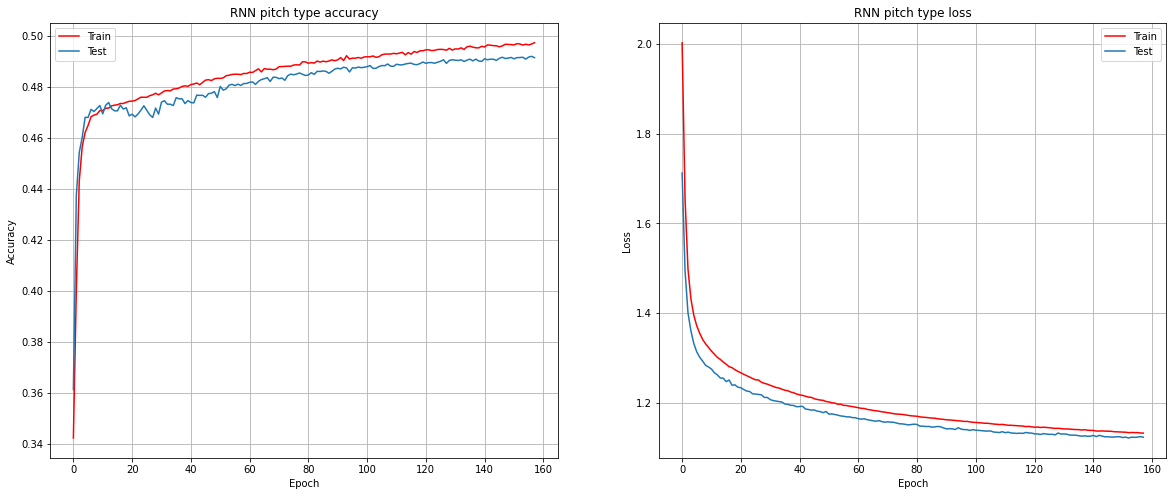

In [ ]:
#RNN
train_iter = kerasIter(train_pitches, train_abs, dynamic_cols, static_cols, target_cols, outcome_cols, 
                       max_batch_size=2024, weights_col='type_confidence', recurrent_mode=True)
test_iter = kerasIter(test_pitches, test_abs, dynamic_cols, static_cols, target_cols, outcome_cols, 
                      max_batch_size=2024, weights_col='type_confidence', recurrent_mode=True)

dynamic_ins = Input(shape=(None,len(dynamic_cols+outcome_cols)))
static_ins = Input(shape=(len(static_cols), ))

static_ins_repeated = Lambda(repeat_vector, output_shape=(None, len(static_cols))) ([static_ins, dynamic_ins])

RL1 = LSTM(200, return_sequences=True, dropout=0.2) (dynamic_ins)
RL1 = LSTM(200, return_sequences=True, dropout=0.2) (RL1)
RL1 = LSTM(200, return_sequences=True, dropout=0.2) (RL1)


dense1_ins = concatenate([RL1, static_ins_repeated])
#dense1_ins = RL1

dense1 = TimeDistributed(Dense(2024, activation='relu')) (dense1_ins)
dense1 = Dropout(0.25) (dense1)
dense1 = TimeDistributed(Dense(2024, activation='relu')) (dense1)
dense1 = Dropout(0.25) (dense1)
dense1 = TimeDistributed(Dense(2024, activation='relu')) (dense1)
dense1 = Dropout(0.25) (dense1)

out = TimeDistributed(Dense(len(target_cols), activation='softmax')) (dense1)
model = Model(inputs=[dynamic_ins, static_ins], outputs=out)
adamopt = Adam(lr=2e-5)
model.compile(optimizer=adamopt,
              loss='categorical_crossentropy',
              sample_weight_mode='temporal',
              metrics=['accuracy'])
# weights_col='type_confidence'

model.summary()


train_plot_model(model, 'RNN pitch type', train_iter, test_iter)